# Collaboration and Competition

---

This notebook runs John's solution for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.  It uses the Unity ML-Agents environment to train two cooperative agents to play a tennis-like game.

**Need more description here - refer to readme?**






...


This code depends upon a custom Unity environment provided by the Udacity staff that embodies the variation on tennis.  It will open a separate Unity window for visualizing the environment as the agents train or play.


In [1]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


The next cell simply prints some verification info about the environment.

In [2]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## Train the agents

The next cells will invoke the training program to create the agents.  All of the real code is in Python flat files in this project directory.

In [3]:
TRAIN = False
EXPLORE = True

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from train import train
from maddpg import Maddpg

%matplotlib inline

if TRAIN:
    
    ##### set up key hyperparams

    EPISODES          = 8000
    RUN_NAME          = '02' #used for config control & naming of checpoint files
    SEED              = 111
    BATCH             = 1000
    TIME_STEPS        = 500
    DECAY             = 0.9999
    LEARN_EVERY       = 10
    LEARN_ITER        = 4

    ##### instantiate the agents and perform the training

    player_a = DdpgAgent(state_size, action_size, random_seed=SEED, batch_size=BATCH, noise_decay=DECAY, 
                         learn_every=LEARN_EVERY, learn_iter=LEARN_ITER)
    player_b = DdpgAgent(state_size, action_size, random_seed=SEED, batch_size=BATCH, noise_decay=DECAY, 
                         learn_every=LEARN_EVERY, learn_iter=LEARN_ITER)

    scores = train(player_a, player_b, env, run_name=RUN_NAME, max_episodes=EPISODES, 
                   winning_score=0.5, max_time_steps=TIME_STEPS)

    ##### plot the training reward history

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

Ready to train over 1 training sets

///// Beginning training set  TEST.01  with:
      Seed             =  0
      Batch size       =  3
      Time steps       =  200
      Learning every      1  time steps
      Learn iterations =  1
Episode 99	Average Score: 0.004, avg 305 episodes/min
Avg time steps/episode = 14.1


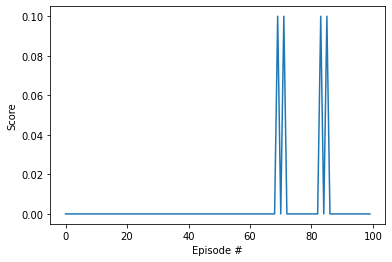



DONE!


In [5]:
# This cell will explore several combinations of hyperparams by training all of them

if EXPLORE:
    
    EPISODES     = 100
    RUN_PREFIX   = "TEST" #next E08
    DECAY        = 0.9995
    SEEDS        = (0,) #(0, 111, 468, 5555, 23100, 44939)
    BATCHES      = (3,)
    TIME_STEPSES = (200,)
    LEARN_EVERYS = (1,)
    LEARN_ITERS  = (1,)
    
    num_sets = len(SEEDS) * len(BATCHES ) * len(TIME_STEPSES) * len(LEARN_EVERYS) * len(LEARN_ITERS)
    print("Ready to train over {} training sets".format(num_sets))
    set_id = 0
    for SEED in SEEDS:
        for BATCH in BATCHES:
            for TIME_STEPS in TIME_STEPSES:
                for LEARN_EVERY in LEARN_EVERYS:
                    for LEARN_ITER in LEARN_ITERS:
                        
                        set_id += 1
                        RUN_NAME = "{}.{:02d}".format(RUN_PREFIX, set_id)
                        print("\n///// Beginning training set ", RUN_NAME, " with:")
                        print("      Seed             = ", SEED)
                        print("      Batch size       = ", BATCH)
                        print("      Time steps       = ", TIME_STEPS)
                        print("      Learning every     ", LEARN_EVERY, " time steps")
                        print("      Learn iterations = ", LEARN_ITER)
    
                        ##### instantiate the agents and perform the training

                        maddpg = Maddpg(state_size, action_size, 2, random_seed=SEED, batch_size=BATCH, 
                                        noise_decay=DECAY, learn_every=LEARN_EVERY, learn_iter=LEARN_ITER)

                        scores = train(maddpg, env, run_name=RUN_NAME, max_episodes=EPISODES, 
                                       winning_score=0.5, max_time_steps=TIME_STEPS)

                        ##### plot the training reward history

                        fig = plt.figure()
                        ax = fig.add_subplot(111)
                        plt.plot(np.arange(len(scores)), scores)
                        plt.ylabel('Score')
                        plt.xlabel('Episode #')
                        plt.show()
                        
    print("\n\nDONE!")

# HEY JOHN - TODO!

- update main.py to match the above code {ALL CELLS}
- Test running from cmd line (may need a script?)
- Clean up the bottom part of this notebook

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
"""
for i in range(10):                                        # play game for several episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations             3     # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    num_steps = 0
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        num_steps += 1
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Episode {}: {:5.3f}, took {} steps'.format(i, np.max(scores), num_steps))
"""

"\nfor i in range(10):                                        # play game for several episodes\n    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    \n    states = env_info.vector_observations             3     # get the current state (for each agent)\n    scores = np.zeros(num_agents)                          # initialize the score (for each agent)\n    num_steps = 0\n    while True:\n        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n        env_info = env.step(actions)[brain_name]           # send all actions to tne environment\n        next_states = env_info.vector_observations         # get next state (for each agent)\n        rewards = env_info.rewards                         # get reward (for each agent)\n        dones = env_info.local_done                        # see if episode finished\n        scores += env_i

When finished, you can close the environment.

In [7]:
env.close()